In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]


# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0],-1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat
    
# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [2]:
# 给一个参数，然后将它发送到哪个GPU上
def get_params(params, device):  
    new_params = [p.to(device) for p in params] 
    for p in new_params:    # 需要计算梯度
        p.requires_grad_()
    return new_params

# 将所有参数复制到一个GPU
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


In [3]:
# 将所有向量相加,并广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)  # 将数据复制到GPU0上进行相加
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)  # GPU0计算得到的结果发送给所有GPU

data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [4]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)  # 将数据均匀切开，分配给每个GPU上
print('input :', data)
print('load into', devices)
print('output:', split)

IndexError: list index out of range

In [5]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [6]:
# 定义一个多GPU训练小批量数据的函数
def train_batch(X, y, device_params, devices, lr): # 输入,所有GPU上的参数，GPU,学习率
    X_shards, y_shards = split_batch(X, y, devices)  # 拆分数据
    # 在每个GPU上分别计算损失, ls中包含了所有GPU中的损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
                    for X_shard, y_shard, device_W in zip(
                        X_shards, y_shards, device_params)]
    for l in ls: # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

In [7]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
        # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()  # 同步一次,保证每个GPU都完成了
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
            f'在{str(devices)}')

测试精度：0.83，8.8秒/轮，在[device(type='cuda', index=0)]


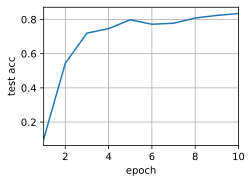

In [8]:
# 单GPU运行
train(num_gpus=1, batch_size=256, lr=0.2)

# 多GPU运行
#train(num_gpus=2, batch_size=256, lr=0.2)